In [1]:
# libraries need
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2 as L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import TensorBoard
import keras
import time

#print("GPU Available: ", tf.test.is_gpu_available())
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-12-03 17:45:20.788469: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 17:45:21.161934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 17:45:22.642644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9978272332923368668
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14366539776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10367470536836853382
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


2023-12-03 17:45:26.038364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 17:45:26.144849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 17:45:26.145432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 17:45:26.486466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 17:45:26.487020: I tensorflow/compile

In [2]:
# load the memmap as numpy arrays 46bd9bde8e91ff4cf5c72bf85b71b0fdb3008ec98ef84d03
imagesFilePath =r'/workspace/shuffled_images.memmap'
labelFilePath = r'/workspace/shuffled_labels.memmap'

numDiv=6

imageShape = (6396, 321, 304, 3)
labelShape = (6396,)
imageMemmap = np.memmap(imagesFilePath, dtype='float32', mode='r', shape=imageShape)
labelMemmap = np.memmap(labelFilePath, dtype='bool', mode='r', shape=labelShape)


distVal=(len(imageMemmap)/numDiv)

indexList=[]

for i in range(numDiv):
   indexList.append(int(i*distVal))

indexList.append(len(imageMemmap))
print(indexList)

slice1=(indexList[0],indexList[1])
slice2=(indexList[1],indexList[2])
slice3=(indexList[2],indexList[3])
slice4=(indexList[3],indexList[4])
slice5=(indexList[4],indexList[5])
slice6=(indexList[5],indexList[6])

iTupLi=[slice1,slice2,slice3,slice4,slice5,slice6]


print(iTupLi) 


#6396
#imageArray = np.array(imageMemmap[0:5])
# labelArray = np.array(labelMemmap)

# print(f'image array: {imageArray.shape}')
# print(f'image[0] array: {imageArray[0].shape}')
# print(f'label array: {labelArray.shape}')



[0, 1066, 2132, 3198, 4264, 5330, 6396]
[(0, 1066), (1066, 2132), (2132, 3198), (3198, 4264), (4264, 5330), (5330, 6396)]


In [3]:
# Split data in train, test
def splitData(slc, imgMmap, labelMmap):
    # 70% for training, 30% for testing
    shape = slc[1] - slc[0]
    imageArray = np.array(imgMmap[slc[0]:slc[1]])
    labelArray = np.array(labelMmap[slc[0]:slc[1]])
    
    breakPoint = int(shape * 0.7)
    labelTrain = labelArray[0:breakPoint]
    labelTest = labelArray[breakPoint:]
    imageTrain = imageArray[0:breakPoint]
    imageTest = imageArray[breakPoint:]

    print(f'Shape: {shape}')
    print('Train Shapes')
    print(imageTrain.shape)
    print(labelTrain.shape)

    print('Test Shapes')
    print(imageTest.shape)
    print(labelTest.shape)
    return imageTrain, imageTest, labelTrain, labelTest


In [4]:
%reload_ext tensorboard
%tensorboard --logdir logs

# create and fit model
def trainSave(learningRate, dropout, batch, epochs, earlyStopPatience,imageTrain, labelTrain,imageTest, labelTest,regularizationWeight,savePath):
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=earlyStopPatience,  verbose=1, mode='min')
    model = binominalModel(learningRate, dropout,imageTrain[0].shape,regularizationWeight)
    print('Starting to fit model')
    
    tensorboard_callback = TensorBoard(log_dir="logs/model_v1_lr{}_dropout{}_{}".format(learningRate, dropout, time.strftime("%Y%m%d-%H%M%S")))
    history = model.fit(imageTrain, labelTrain, batch_size=batch,epochs=epochs, validation_data=(imageTest, labelTest),callbacks=[earlystop,tensorboard_callback])

    print('Evaluating model')
    score = model.evaluate(imageTest, labelTest)
    print()
    print('Test accuracy: ', score[1])
    
    print('Saving Model')
    
    savePath+=str(round(score[1]*100,2))+'.keras'
    
    model.save(savePath)
    # return the loss,validation loss, accuracy for graphing purposes
    return history.history['loss'], history.history['val_loss'], score[1]
    
def saveLossGraph(train_loss,val_loss, savePath):
    fig, ax = plt.subplots()
    ax.plot(train_loss,c = 'r')
    ax.plot(val_loss,c = 'b')
    ax.set_ylabel('Loss')
    ax.legend(['train','val'],loc = 'upper right')
    fig.savefig(savePath)
    # plt.show()

# %reload_ext tensorboard

Reusing TensorBoard on port 6006 (pid 583), started 3:37:45 ago. (Use '!kill 583' to kill it.)

In [5]:
# model to train with
def binominalModel(learnRate,dropout, input_shape,regularizationWeight):
  model = Sequential()

  model.add(Conv2D(8, (3, 3), input_shape=input_shape,activation='relu',kernel_initializer='he_normal',kernel_regularizer=L2(regularizationWeight)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout))
  
  # model.add(Conv2D(16, (3, 3),activation='relu',kernel_initializer='he_normal',kernel_regularizer=L2(regularizationWeight)))
  # model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout))

  # model.add(Conv2D(32, (3, 3),activation='relu',kernel_initializer='he_normal',kernel_regularizer=L2(regularizationWeight)))
  # model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout-0.1))

  # model.add(Conv2D(16, (3, 3),activation='relu',kernel_initializer='he_normal',kernel_regularizer=L2(regularizationWeight)))
  # model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout))

  model.add(Flatten())
  
  # model.add(Dense(64, activation='relu',kernel_initializer='he_normal',kernel_regularizer=L2(regularizationWeight)))
  # model.add(Dropout(dropout))
  
  model.add(Dense(32, activation='relu',kernel_initializer='he_normal',kernel_regularizer=L2(regularizationWeight)))
  model.add(Dropout(dropout))

  model.add(Dense(16, activation='relu',kernel_initializer='he_normal',kernel_regularizer=L2(regularizationWeight)))
  model.add(Dropout(dropout))
  
  model.add(Dense(1, activation='sigmoid'))

  optimizer = keras.optimizers.Adam(learning_rate=learnRate)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

Shape: 1066
Train Shapes
(746, 321, 304, 3)
(746,)
Test Shapes
(320, 321, 304, 3)
(320,)
Data sliced
Starting Training


2023-12-03 17:45:28.304739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 17:45:28.305666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 17:45:28.306477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 17:45:28.307384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 17:45:28.307403: I tensorflow/core/co

Starting to fit model
Epoch 1/100


2023-12-03 17:45:31.303275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-03 17:45:31.723626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2023-12-03 17:45:32.241558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-03 17:45:32.359371: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f65ecdb5f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 17:45:32.359423: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2023-12-03 17:45:32.413326: I tensorflow/compiler/mlir/tensorflow/utils

12/12 [==============================] - 8s 352ms/step - loss: 6.1905 - accuracy: 0.5295 - val_loss: 2.0995 - val_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 1s 55ms/step - loss: 2.5285 - accuracy: 0.5362 - val_loss: 0.6656 - val_accuracy: 0.5594
Epoch 3/100
12/12 [==============================] - 1s 49ms/step - loss: 0.9512 - accuracy: 0.5362 - val_loss: 0.6712 - val_accuracy: 0.5656
Epoch 4/100
12/12 [==============================] - 1s 45ms/step - loss: 0.6861 - accuracy: 0.5670 - val_loss: 0.6917 - val_accuracy: 0.5250
Epoch 5/100
12/12 [==============================] - 1s 44ms/step - loss: 0.6807 - accuracy: 0.5737 - val_loss: 0.6760 - val_accuracy: 0.5719
Epoch 6/100
12/12 [==============================] - 1s 43ms/step - loss: 0.6766 - accuracy: 0.5777 - val_loss: 0.6716 - val_accuracy: 0.5719
Epoch 7/100
12/12 [==============================] - 1s 44ms/step - loss: 0.6655 - accuracy: 0.5952 - val_loss: 0.6813 - val_accuracy: 0.5688
Epoch 8/100
12/12

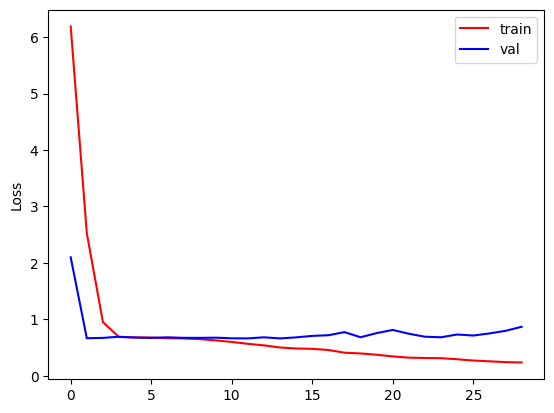

: 

In [6]:
# Main
# parameters
batch = 64
epochs = 100
learningRate = 0.000027
dropout = 0.05
regularizationWeight = 0.0
earlyStopPatience = 15

modelNumber = 1
currentSlice = slice1


modelSavePath=rf'modelSaves/model1/model{modelNumber}_'
imageTrain, imageTest, labelTrain, labelTest = splitData(currentSlice, imageMemmap, labelMemmap)
print('Data sliced')
print("Starting Training")
train_error, val_error,accuracy = trainSave(regularizationWeight=regularizationWeight,learningRate=learningRate, dropout=dropout, batch=batch, earlyStopPatience=earlyStopPatience, epochs=epochs, imageTrain=imageTrain, imageTest=imageTest, labelTrain=labelTrain, labelTest=labelTest, savePath=modelSavePath)
graphStatsSavePath = rf'modelSaves/model{modelNumber}/{round(accuracy*100,2)}_trainLoss.png'
saveLossGraph(train_error, val_error, graphStatsSavePath)
    